In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
#import h5py
#import tqdm

In [2]:
data = np.loadtxt('mantz - rhodata.txt')
rhodata = data[:,0]
rhoerr = data[:,1]
z = data[:,2]

In [3]:
rhodata[0:2]

array([24.19183457, 25.31151382])

In [4]:
z[0:2]

array([0.0779, 0.0882])

Text(0, 0.5, '$\\rho_{DM}$')

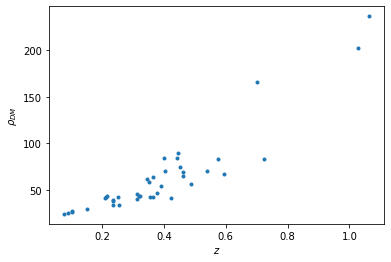

In [5]:
plt.plot(z,rhodata,'.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_{DM}$')

Text(0, 0.5, '$\\rho_{DM}$')

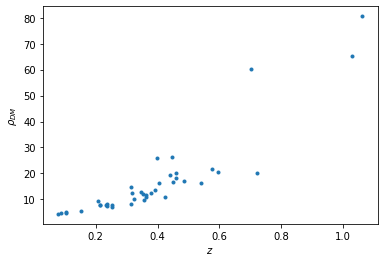

In [6]:
plt.plot(z,rhoerr,'.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_{DM}$')

## Standard least square fitting

In [7]:
def rhodm_func(z, rho0):
    return rho0 * (1+z)**3

In [8]:
popt, pcov = curve_fit(rhodm_func, z, rhodata)
print(popt, pcov)

[23.13765631] [[0.60232819]]


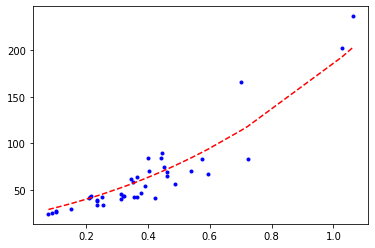

In [9]:
plt.plot(z, rhodata, 'b.')
plt.plot(z, rhodm_func(z, *popt), 'r--')

## MCMC

In [10]:
def loglikelihood(theta, rhodata, rhoerr, z):
    #ini adalah natural log dari likelihood
    #tulis modelnya
    
    rhocdm0 = theta
    md = rhocdm0*((1+z)**3)
    
    #keluarin likelihoodnya
    return -0.5*np.sum(np.log(2*np.pi*(rhoerr**2))+((rhodata - md)**2/rhoerr**2))


def logprior(theta):
#ini adalah natural log dari priornya
    rhocdm0 = theta	
    rhomax = 31
    rhomin = 15
    if rhomin < rhocdm0 < rhomax:
        lp = 0
    else:
        lp = -np.inf
    return lp


def logposterior(theta, rhodata, rhoerr, z):
    #ini adalah natural log dari posterior.
    #theta: parameternya
    #rhodata: nilai rhocdmdata
    #rhoerr: errornya
    lp = logprior(theta) #untuk mendapatkan prior
    
    #kalau prior tak hingga maka tidak diterima
    if not np.isfinite(lp):
        return -np.inf
    
    #kalau diterima, maka keluarkan likelihood+priornya
    return lp + loglikelihood(theta, rhodata, rhoerr, z)

In [11]:
nwalker = 200
ndims = 1
nsteps = 2000
#ngeset nilai awal untuk memulai sampling
guess = np.zeros(ndims)
scale = np.ones(ndims)
guess[0] = 24
scale[0] = 1
np.random.seed(42)

p0 = np.random.randn(nwalker, ndims)*scale+guess

#set additional args for the posterior (the data, err, and z)
argslist = (rhodata, rhoerr, z)
#set up the sampler
#a_parameter = 10
#move = emcee.moves.StretchMove(a=a_parameter)
sampler = emcee.EnsembleSampler(nwalker, ndims, logposterior,args=argslist)
sampler.run_mcmc(p0,nsteps,progress=True) 

#mengecek konvergensi, dengan cara mengecek autocorr time setiap 100 step, 
#kalao chain nya udah lebih panjang dari 100 kali  autocorr time dan perubahannya kurang dari 1% maka 
#dianggap konvergen


#menyimpan dalam file txt

samples = sampler.get_chain(flat=True)

# with open('test_10000.txt', 'w') as outfile:
#     outfile.write('#Array shape: {0}\n'.format(samples.shape))
#     for data_slice in samples:
#         np.savetxt(outfile, data_slice, fmt='%-7.2f')
#         outfile.write('# New slice\n')
# #melihat probabilitas posterior
# samples_prob = sampler.get_log_prob(discard = 100)
# with open('logprob_10000.txt', 'w') as outfile:
#     outfile.write('#Array shape: {0}\n'.format(samples_prob.shape))
#     for data_slice in samples_prob:
#         np.savetxt(outfile, data_slice, fmt='%-7.2f')
#         outfile.write('# New slice\n')


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

100%|██████████| 2000/2000 [00:30<00:00, 65.27it/s]


Mean acceptance fraction: 0.805
Mean autocorrelation time: 24.185 steps


[]

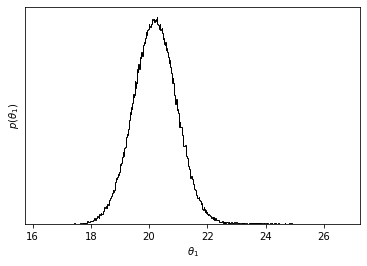

In [12]:
plt.figure(1)
plt.hist(samples[:,0], 500, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([])
#plt.savefig("histogram_5000");

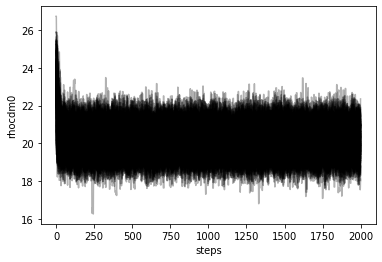

In [13]:
plt.figure(2)
for i in range(ndims):
    res=plt.plot(sampler.chain[:,:,0].T,color='k', alpha=0.3)
    plt.xlabel("steps")
    plt.ylabel("rhocdm0")
#plt.savefig("trace_5000")


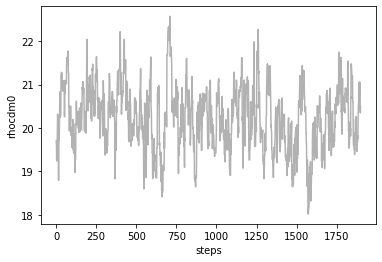

In [14]:
samples2 = sampler.get_chain(discard=100)
plt.figure(3)
for i in range(ndims):
    plt.plot(samples2[:,0],color='k', alpha=0.3)
    plt.xlabel("steps")
    plt.ylabel("rhocdm0")
#plt.savefig("trace_discarded100")

In [15]:
#mengeluarkan error
for i in range(ndims):
    mcmc = np.percentile(samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(mcmc[1], q[0], q[1])

20.2803932325046 0.7542843718487404 0.6745725280669852
